# 🔬 CNN

### ⚙️ Importing Libraries & Environment Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 📥 Loading the Dataset

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X.astype(np.float32) / 255.0
y = y.astype(np.int64)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# Convert numpy arrays to PyTorch tensors with appropriate dtypes
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# Build a DataLoader for mini-batch training (shuffle each epoch)
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=256,
    shuffle=True,
    drop_last=False,  # keep the last smaller batch
)

### 🏋️‍♂️ Model Training

In [4]:
@torch.no_grad()
def predict(
    model: nn.Module,
    X_t: Tensor,
    device: torch.device | str,
    batch_size: int = 512,
) -> np.ndarray:
    """Run inference and return predicted class indices.

    Args:
        model: A PyTorch model returning logits of shape (N, C).
        X_t: Input tensor of shape (N, ...).
        device: Device on which to run inference.
        batch_size: Mini-batch size for inference.

    Returns:
        NumPy array of predicted class indices of shape (N,).
    """
    model.eval()
    preds: list[Tensor] = []

    for i in range(0, X_t.size(0), batch_size):
        xb = X_t[i : i + batch_size].to(device, non_blocking=True)
        logits = model(xb)
        preds.append(logits.argmax(dim=1).cpu())

    return torch.cat(preds).numpy()


def train(
    model: nn.Module,
    title: str,
    train_loader: DataLoader[tuple[Tensor, Tensor]],
    X_test_t: Tensor,
    y_test: np.ndarray,
    epochs: int = 100,
    weight_decay: float = 0.0,
    device: torch.device | str = "cpu",
) -> tuple[nn.Module, dict[str, list[float]]]:
    """Train a model for a fixed number of epochs and track metrics.

    Training uses Adam optimizer and StepLR scheduler.

    Args:
        model: Model to train.
        title: Label used for progress bar display.
        train_loader: DataLoader yielding (xb, yb) mini-batches.
        X_test_t: Test features as a torch tensor.
        y_test: Ground-truth test labels as a NumPy array.
        epochs: Number of epochs to train.
        weight_decay: L2 regularization coefficient.
        device: Device for training/inference.

    Returns:
        Tuple containing:
            - Trained model.
            - History dictionary with keys:
              ["train_loss", "train_acc", "test_acc"].
    """
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "test_acc": []}

    epoch_bar = tqdm(range(1, epochs + 1), desc=title)
    for _ in epoch_bar:
        model.train()

        train_loss_sum = 0.0
        train_acc_sum = 0.0
        total = 0

        for xb, yb in train_loader:
            xb_device = xb.to(device)
            yb_device = yb.to(device)

            opt.zero_grad(set_to_none=True)
            logits = model(xb_device)
            loss = loss_fn(logits, yb_device)
            loss.backward()
            opt.step()

            train_loss_sum += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            train_acc_sum += (pred == yb_device).sum().item()
            total += xb.size(0)

        scheduler.step()

        train_loss = train_loss_sum / total
        train_acc = train_acc_sum / total

        test_preds = predict(model, X_test_t, device=device)
        test_acc = accuracy_score(y_test, test_preds)

        epoch_bar.set_postfix(
            train_loss=f"{train_loss:.4f}",
            train_acc=f"{train_acc:.4f}",
            test_acc=f"{test_acc:.4f}",
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

    return model, history

In [5]:
class CNN(nn.Module):
    """Convolutional Neural Network for image classification (e.g. MNIST).

    Architecture:
        - Conv2d(1 → 32) + ReLU + MaxPool
        - Conv2d(32 → 64) + ReLU + MaxPool
        - Dropout
        - Fully Connected (3136 → 128) + ReLU
        - Dropout
        - Fully Connected (128 → num_classes)

    Expected input shape:
        (N, 1, 28, 28)

    Output:
        Logits tensor of shape (N, num_classes)
    """

    def __init__(self, num_classes: int = 10) -> None:
        """Initialize the CNN model.

        Args:
            num_classes (int, optional): Number of output classes.
                Defaults to 10.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Perform a forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (N, 1, 28, 28).

        Returns:
            torch.Tensor: Logits tensor of shape (N, num_classes).
        """
        return self.net(x)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [8]:
model = CNN().to(device)
model, results = train(
    model, "MNIST CNN", train_loader, X_test_t, y_test, device=device
)

MNIST CNN: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s, test_acc=0.9930, train_acc=0.9998, train_loss=0.0008]


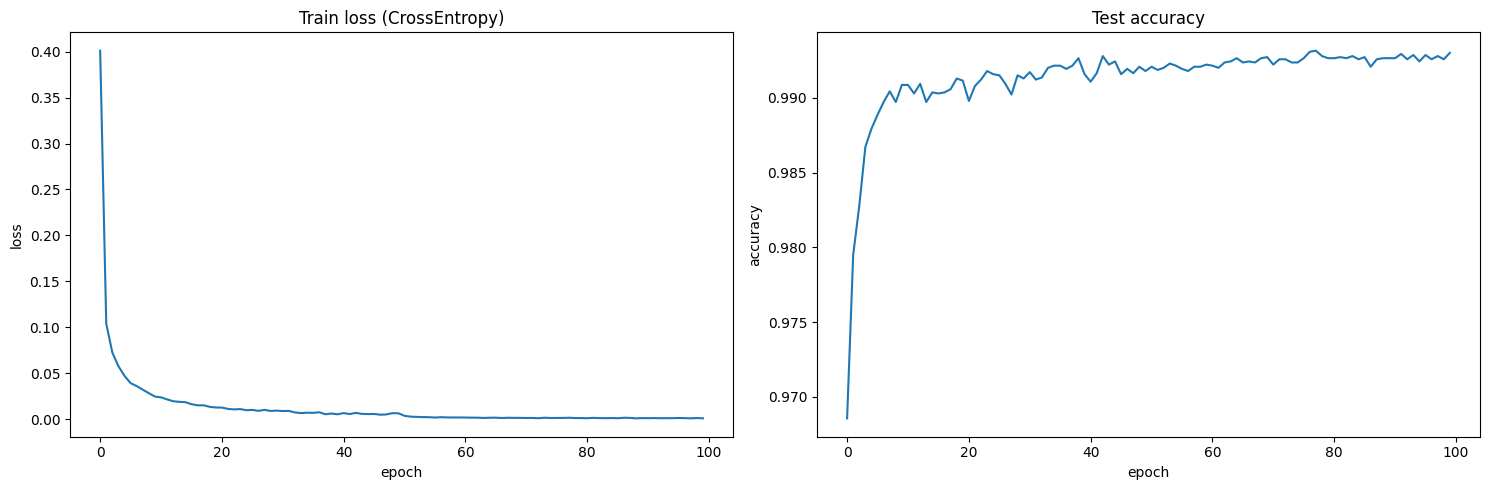

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(results["train_loss"])
plt.title("Train loss (CrossEntropy)")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(results["test_acc"])
plt.title("Test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.tight_layout()
plt.show()